# RoBERTa PyTorch

##### https://www.kaggle.com/menion/sentiment-analysis-with-bert-87-accuracy
---

In [1]:
import os
import warnings
import random
import torch
from torch import nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import tokenizers
from transformers import RobertaModel, RobertaConfig

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, f1_score

warnings.filterwarnings('ignore')


In [28]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)


In [29]:
from BertLibrary import BertFTModel
import numpy as np

In [4]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

zsh:1: command not found: wget
unzip:  cannot find or open uncased_L-12_H-768_A-12.zip, uncased_L-12_H-768_A-12.zip.zip or uncased_L-12_H-768_A-12.zip.ZIP.


In [30]:
ft_model = BertFTModel( model_dir='uncased_L-12_H-768_A-12',
                        ckpt_name="bert_model.ckpt",
                        labels=['-1','0','1'],
                        lr=1e-05,
                        num_train_steps=30000,
                        num_warmup_steps=1000,
                        ckpt_output_dir='output',
                        save_check_steps=1000,
                        do_lower_case=False,
                        max_seq_len=50,
                        batch_size=32,
                        )


ft_trainer =  ft_model.get_trainer()
ft_evaluator = ft_model.get_evaluator()

INFO:tensorflow:Using config: {'_model_dir': 'output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': device_count {
  key: "GPU"
  value: 1
}
gpu_options {
  per_process_gpu_memory_fraction: 0.5
  allow_growth: true
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff54c5c52b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Read Cleaned Data

In [2]:
# load the dataset
oba_cleanall = np.load('./TrainData/tweets_oba.npy', allow_pickle=True)
targets_oba = np.load('./TrainData/targets_oba.npy', allow_pickle=True)
rom_cleanall = np.load('./TrainData/tweets_rom.npy', allow_pickle=True)
targets_rom = np.load('./TrainData/targets_rom.npy', allow_pickle=True)
df_oba = pd.DataFrame({'label': targets_oba, 'text':oba_cleanall})
df_rom = pd.DataFrame({'label': targets_rom,'text':rom_cleanall})

In [3]:
df_oba.head()

,label,text
0,0,kirkpatrick wore baseb cap embroid barack obam...
1,1,obama debat cracker cracker tonight tune teamo...
2,0,miss point im afraid understand bigger pictur ...
3,-1,wa rai democrat left parti year ago lifetim ne...
4,0,obama camp cant afford lower expect tonight de...


In [4]:
df_rom.head()

,label,text
0,-1,insidiousmitt romney bain help philip morri ge...
1,-1,mean like romney cheat primari
2,-1,mitt romney still doesnt believ black presid
3,-1,romney tax plan deserv nd look becau ha secret...
4,1,hope romney debat prep w peopl last time


<AxesSubplot:xlabel='label', ylabel='count'>

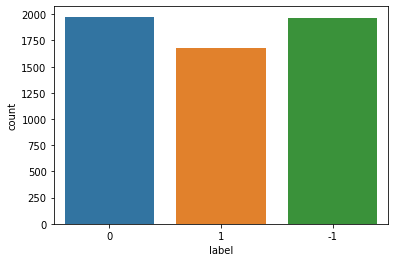

In [34]:
sns.countplot(df_oba['label'])

NameError: name 'sns' is not defined

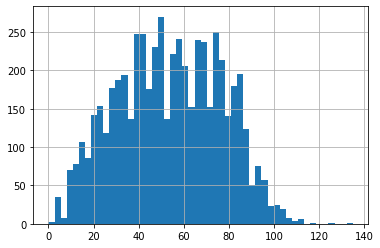

In [20]:
df_oba['text_length'] = df_oba['text'].apply(len)
df_oba[['label','text_length','text']].head()
df_oba['text_length'].describe()
df_oba['text_length'].hist(bins=50)
g = sns.FacetGrid(df_oba,col='label')
g.map(plt.hist,'text_length')

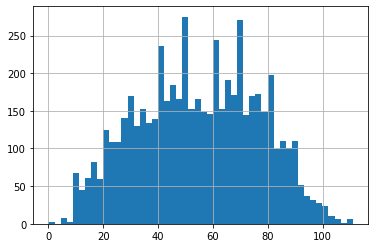

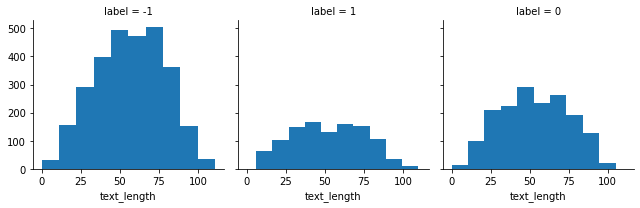

In [36]:
df_rom['text_length'] = df_rom['text'].apply(len)
df_rom[['label','text_length','text']].head()
df_rom['text_length'].describe()
df_rom['text_length'].hist(bins=50)
g = sns.FacetGrid(df_rom,col='label')
g.map(plt.hist,'text_length')

In [41]:
TRAIN_SIZE = 0.75
VAL_SIZE = 0.05
dataset_count = len(df_oba)

df_train_val, df_test = train_test_split(df_oba, test_size=1-TRAIN_SIZE-VAL_SIZE, random_state=42)
df_train, df_val = train_test_split(df_oba, test_size=VAL_SIZE / (VAL_SIZE + TRAIN_SIZE), random_state=42)

print("TRAIN size:", len(df_train))
print("VAL size:", len(df_val))
print("TEST size:", len(df_test))

TRAIN size: 5272
VAL size: 352
TEST size: 1125


In [42]:
!mkdir dataset
df_train.sample(frac=1.0).reset_index(drop=True).to_csv('dataset/train.tsv', sep='\t', index=None, header=None)
df_val.to_csv('dataset/dev.tsv', sep='\t', index=None, header=None)
df_test.to_csv('dataset/test.tsv', sep='\t', index=None, header=None)
! cd dataset && ls

mkdir: dataset: File exists
dev.tsv         test.tsv        train.tf-record train.tsv


In [45]:
!mkdir output

mkdir: output: File exists


In [48]:
ft_trainer.train_from_file('dataset', 35000)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 1000 or save_checkpoints_secs None.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (32, 50)
INFO:tensorflow:  name = input_mask, shape = (32, 50)
INFO:tensorflow:  name = is_real_example, shape = (32,)
INFO:tensorflow:  name = label_ids, shape = (32,)
INFO:tensorflow:  name = segment_ids, shape = (32, 50)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (5

In [47]:
ft_evaluator.evaluate_from_file('dataset', checkpoint="output/model.ckpt-1")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (?, 50)
INFO:tensorflow:  name = input_mask, shape = (?, 50)
INFO:tensorflow:  name = is_real_example, shape = (?,)
INFO:tensorflow:  name = label_ids, shape = (?,)
INFO:tensorflow:  name = segment_ids, shape = (?, 50)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name =

In [49]:
X, X_val, y, y_val = train_test_split(df_oba['text'], df_oba['label'], test_size=0.2, random_state=42)
ft_trainer.train(X, y, X_val=X_val, y_val=y_val, steps=60000)

INFO:tensorflow:Writing example 0 of 4498
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 1
INFO:tensorflow:tokens: [CLS] guess u didn ##t read link sent u even con ##ser ##v like k ##ra ##uth ##am ##m laura ing ##rah ##am said obama [SEP]
INFO:tensorflow:input_ids: 101 3984 1057 2134 2102 3191 4957 2741 1057 2130 9530 8043 2615 2066 1047 2527 14317 3286 2213 6874 13749 10404 3286 2056 8112 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:label: 1 (id = 2)
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 2
INFO:tensorflow:tokens: [CLS] mo ##vi idea obama acc ##id sign afford car ##b act la ##rg pizza like cent [SEP]
INFO:tensorflow:input_ids: 101 9587 5737 2801 8112 16222 3593 3696 8984 2482 2497 2552 24

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [53]:
print(y_val)

3494    -1
1609     1
1097    -1
2302     0
4500     1
        ..
3296     0
1514    -1
2700     0
731      0
291      0
Name: label, Length: 1125, dtype: object


In [23]:
import json
import random
import warnings
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adagrad
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

In [24]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
bert = AutoModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")

In [7]:
def feature_extraction(text):
    x = tokenizer.encode(text)
    with torch.no_grad():
        x, _ = bert(torch.stack([torch.tensor(x)]).to('cpu'))
        return list(x[0][0].cpu().numpy())

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_oba['text'], df_oba['label'],test_size=0.2,random_state=42)

In [6]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [9]:
tokenx = df_oba['text'].apply(lambda x: tokenizer.encode(x))



In [37]:
tokenx

0       [74, 14232, 29615, 12408, 2779, 65, 1451, 4072...
1       [672, 1689, 1915, 265, 8469, 263, 8469, 263, 9...
2       [3927, 966, 545, 7787, 1833, 5749, 2862, 333, ...
3       [10247, 374, 1872, 43268, 1364, 636, 72, 614, ...
4       [672, 1689, 1413, 18548, 5368, 2793, 1607, 997...
                              ...                        
5619    [16341, 2415, 670, 348, 787, 443, 5508, 331, 9...
5620    [820, 1742, 2922, 1742, 443, 37686, 479, 268, ...
5621    [41181, 1529, 9267, 1681, 12314, 2978, 909, 16...
5622    [672, 1689, 479, 268, 461, 272, 269, 1939, 259...
5623    [65, 2007, 588, 909, 1689, 21551, 765, 2057, 1...
Name: text, Length: 5624, dtype: object


In [10]:
X_bert = []
for i in tokenx:
    print(i)
    if(len(i)!=0):
        x, _ = bert(torch.stack([torch.tensor(i)]).to('cpu'))
        with torch.no_grad():
            X_bert.append(list(x[0][0].cpu().numpy()))
# x, _ = bert(torch.stack([torch.tensor(tokenx)]).to('cpu'))

[101, 11332, 4502, 22881, 5078, 2918, 2497, 6178, 7861, 12618, 3593, 13857, 8112, 3696, 4017, 3126, 6865, 16168, 2298, 4463, 7367, 12439, 18092, 3485, 102]
[101, 8112, 2139, 14479, 8579, 2121, 8579, 2121, 3892, 8694, 2136, 16429, 8067, 102]
[101, 3335, 2391, 10047, 4452, 3305, 7046, 27263, 20689, 2123, 2102, 2729, 8112, 11322, 102]
[101, 11333, 15547, 7672, 2187, 2112, 2072, 2095, 3283, 2166, 3775, 2213, 2196, 2464, 3653, 5332, 2094, 4487, 17258, 4175, 3089, 2066, 8112, 102]
[101, 8112, 3409, 2064, 2102, 8984, 2896, 5987, 3892, 2139, 14479, 3653, 5332, 2094, 2442, 2507, 2844, 4685, 102]
[101, 8112, 8962, 14955, 28775, 4487, 3736, 9397, 25785, 2360, 2560, 4190, 4886, 4371, 4183, 3081, 102]
[101, 5365, 5292, 7632, 2067, 19387, 4962, 21934, 8202, 23178, 8112, 2490, 2655, 18138, 24667, 2099, 3653, 5332, 2094, 102]
[101, 8112, 4654, 5669, 2072, 3713, 4189, 2344, 10944, 20377, 28168, 15444, 7447, 6980, 1043, 22895, 102]
[101, 3959, 11333, 5610, 8112, 1051, 2080, 102]
[101, 2899, 2051, 3653, 

In [ ]:
print(X_bert)

In [44]:
tokenx.apply(len).unique()


array([24, 13, 22, 16, 20, 17,  7, 19, 14,  5, 18,  8, 11, 12, 15,  4, 21,
       27, 25,  3,  9, 23, 10,  6,  2, 28, 29, 26,  1, 31, 30, 32, 34,  0,
       47, 41, 38, 44, 40])

In [8]:
tokenx = df_oba['text'].apply(lambda x: tokenizer.encode(x))
#
# for i, token in enumerate(tokenx):
#     if(len(token)==0):
#         print("empty!")
#         df_oba = df_oba.drop([i])
# tokenx = df_oba['text'].apply(lambda x: tokenizer.encode(x))
print(tokenx.apply(len).unique())

[25 14 15 24 19 17 20  8 22  6 18  9 21 13 12 11 26  5 16 23 27 29  4  7
 10  3 28 30 31 35 32 34 39 33  2 47 40 41 36 37]


In [49]:
tokenx = df_oba['text'].apply(lambda x: tokenizer.encode(x))


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Ｘ_bert, df_oba['label'],test_size=0.2,random_state=42)
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [25]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.argmax(y_train, 1)), np.argmax(y_train, 1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model = Sequential()
model.add(Dense(512, activation='tanh', input_shape=(1024,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               393728    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [26]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size=64,
                    epochs=500,
                    verbose=1,
                    validation_data=(y_train, y_test),
                    class_weight=class_weights,
                    callbacks = [es])

y_true, y_pred = np.argmax(y_test, 1), np.argmax(model.predict(X_test), 1)
print(classification_report(y_true, y_pred, digits=3))

NameError: name 'X_val' is not defined

In [13]:
X_bert = np.load('berttmp.npy', allow_pickle=True)

In [15]:
X_train, X_test, y_train, y_test


(array([[ 0.9119804 ,  1.3051277 , -2.1813152 , ..., -0.8546489 ,
          0.2842651 , -0.25210845],
        [ 1.479919  ,  0.7658008 , -1.1225665 , ...,  0.63767815,
         -2.196493  , -0.04370321],
        [ 1.1244574 ,  0.55372727, -2.1079757 , ..., -1.5571388 ,
         -0.9333923 , -1.9858152 ],
        ...,
        [ 2.066031  , -0.3927076 , -0.9397117 , ...,  0.02460531,
         -0.04432229,  0.18461314],
        [ 2.2022812 ,  1.9090172 , -1.4300479 , ...,  0.00305502,
         -2.746216  , -1.0621736 ],
        [ 1.9783487 ,  0.85807705, -0.6865195 , ..., -1.0778959 ,
         -0.58433694, -1.3268623 ]], dtype=float32),
 array([[ 0.28867584,  0.34640032, -1.2193259 , ..., -1.4088712 ,
         -1.9449477 , -0.55221695],
        [ 1.4183723 , -0.4820451 , -0.9134673 , ..., -1.6383657 ,
         -1.0273561 , -1.2630734 ],
        [ 0.15945393,  1.4785466 , -0.9390564 , ..., -0.8451362 ,
          0.0207299 , -2.324506  ],
        ...,
        [ 0.4767852 ,  0.7825499 , -1.0

In [27]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size=64,
                    epochs=500,
                    verbose=1,
                    validation_data=(y_train, y_test),
                    class_weight=class_weights,
                    callbacks = [es])


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [4]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [5]:
def pretty_print(result):
    df = pd.DataFrame([result]).T
    df.columns = ["values"]
    return df


In [6]:
def create_tokenizer_from_hub_module(bert_model_hub):
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(bert_model_hub)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])

  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

def make_features(dataset, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN):
    input_example = dataset.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN],
                                                                   text_b = None,
                                                                   label = x[LABEL_COLUMN]), axis = 1)
    features = bert.run_classifier.convert_examples_to_features(input_example, label_list, MAX_SEQ_LENGTH, tokenizer)
    return features

def create_model(bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      bert_model_hub,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(bert_model_hub, num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics.
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

def estimator_builder(bert_model_hub, OUTPUT_DIR, SAVE_SUMMARY_STEPS, SAVE_CHECKPOINTS_STEPS, label_list, LEARNING_RATE, num_train_steps, num_warmup_steps, BATCH_SIZE):

    # Specify outpit directory and number of checkpoint steps to save
    run_config = tf.estimator.RunConfig(
        model_dir=OUTPUT_DIR,
        save_summary_steps=SAVE_SUMMARY_STEPS,
        save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

    model_fn = model_fn_builder(
      bert_model_hub = bert_model_hub,
      num_labels=len(label_list),
      learning_rate=LEARNING_RATE,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps)

    estimator = tf.estimator.Estimator(
      model_fn=model_fn,
      config=run_config,
      params={"batch_size": BATCH_SIZE})
    return estimator, model_fn, run_config


In [7]:
def run_on_dfs(train, test, DATA_COLUMN, LABEL_COLUMN,
               MAX_SEQ_LENGTH = 128,
              BATCH_SIZE = 32,
              LEARNING_RATE = 2e-5,
              NUM_TRAIN_EPOCHS = 3.0,
              WARMUP_PROPORTION = 0.1,
              SAVE_SUMMARY_STEPS = 100,
               SAVE_CHECKPOINTS_STEPS = 10000,
              bert_model_hub = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"):

    label_list = train[LABEL_COLUMN].unique().tolist()

    tokenizer = create_tokenizer_from_hub_module(bert_model_hub)

    train_features = make_features(train, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN)
    test_features = make_features(test, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN)

    num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
    num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

    estimator, model_fn, run_config = estimator_builder(
                                  bert_model_hub,
                                  OUTPUT_DIR,
                                  SAVE_SUMMARY_STEPS,
                                  SAVE_CHECKPOINTS_STEPS,
                                  label_list,
                                  LEARNING_RATE,
                                  num_train_steps,
                                  num_warmup_steps,
                                  BATCH_SIZE)

    train_input_fn = bert.run_classifier.input_fn_builder(
        features=train_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=True,
        drop_remainder=False)

    estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

    test_input_fn = run_classifier.input_fn_builder(
        features=test_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=False,
        drop_remainder=False)

    result_dict = estimator.evaluate(input_fn=test_input_fn, steps=None)
    return result_dict, estimator


In [8]:
import random
random.seed(10)


In [9]:
OUTPUT_DIR = 'output'


In [10]:
# train = df_oba.sample(len(df_oba))

train, test = train_test_split(df_oba, test_size=0.2, random_state=42)

In [11]:
train, test


(     label                                               text
 184      0    paid obama victori fund suppo send posit messag
 2728     1  guess u didnt read link sent u even conserv li...
 2024     0  movi idea obama accid sign afford carb act lar...
 4412    -1                        michel obama one tall bitch
 533     -1  ohio coal miner obama stop lie particip romney...
 ...    ...                                                ...
 3772     0         pre obama believ privat enterpri creat job
 5191     1                     poll show obama lead three via
 5226     0              height popularityeven presid obama ob
 5390     1                                obama got thi obama
 860     -1                   list obama lie updat tcot lnyhbt
 
 [4499 rows x 2 columns],
      label                                               text
 3494    -1  coal miner ask obama stop absolut lie steubenv...
 1609     1  aboutdamntim rt obama wa awesom tonit presiden...
 1097    -1  fact presid ob

In [16]:
myparam = {
        "DATA_COLUMN": "text",
        "LABEL_COLUMN": "label",
        "LEARNING_RATE": 2e-5,
        "NUM_TRAIN_EPOCHS":3,
        "bert_model_hub":"https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"
    }


In [ ]:
result, estimator = run_on_dfs(train, test, **myparam)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Writing example 0 of 4499
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] paid o ##ba ##ma v ##ict ##ori fund su ##pp ##o send p ##os ##it mess ##ag [SEP]
INFO:tensorflow:input_ids: 101 3004 184 2822 1918 191 17882 9012 5841 28117 8661 1186 3952 185 2155 2875 6477 8517 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Writing example 0 of 4499
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] paid o ##ba ##ma v ##ict ##ori fund su ##pp ##o send p ##os ##it mess ##ag [SEP]
INFO:tensorflow:input_ids: 101 3004 184 2822 1918 191 17882 9012 5841 28117 8661 1186 3952 185 2155 2875 6477 8517 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [12]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

